<center>
    <h1>TME3</h1>
    <h5>Olivier RISSER-MAROIX</h5>
</center>    

## 1. Préparation / visualisation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

def read_file ( filename ):
    """
    Lit un fichier USPS et renvoie un tableau de tableaux d'images.
    Chaque image est un tableau de nombres réels.
    Chaque tableau d'images contient des images de la même classe.
    Ainsi, T = read_file ( "fichier" ) est tel que T[0] est le tableau
    des images de la classe 0, T[1] contient celui des images de la classe 1,
    et ainsi de suite.
    """
    # lecture de l'en-tête
    infile = open ( filename, "r" )    
    nb_classes, nb_features = [ int( x ) for x in infile.readline().split() ]

    # creation de la structure de données pour sauver les images :
    # c'est un tableau de listes (1 par classe)
    data = np.empty ( 10, dtype=object )   
    filler = np.frompyfunc(lambda x: list(), 1, 1)
    filler( data, data )

    # lecture des images du fichier et tri, classe par classe
    for ligne in infile:
        champs = ligne.split ()
        if len ( champs ) == nb_features + 1:
            classe = int ( champs.pop ( 0 ) )
            data[classe].append ( list ( map ( lambda x: float(x), champs ) ) )
    infile.close ()

    # transformation des list en array
    output  = np.empty ( 10, dtype=object )
    filler2 = np.frompyfunc(lambda x: np.asarray (x), 1, 1)
    filler2 ( data, output )

    return output

def display_image ( X ):
    """
    Etant donné un tableau X de 256 flotants représentant une image de 16x16
    pixels, la fonction affiche cette image dans une fenêtre.
    """
    # on teste que le tableau contient bien 256 valeurs
    if X.size != 256:
        raise ValueError ( "Les images doivent être de 16x16 pixels" )

    # on crée une image pour imshow: chaque pixel est un tableau à 3 valeurs
    # (1 pour chaque canal R,G,B). Ces valeurs sont entre 0 et 1
    Y = X / X.max ()
    img = np.zeros ( ( Y.size, 3 ) )
    for i in range ( 3 ):
        img[:,i] = X

    # on indique que toutes les images sont de 16x16 pixels
    img.shape = (16,16,3)

    # affichage de l'image
    plt.imshow( img )
    plt.show ()

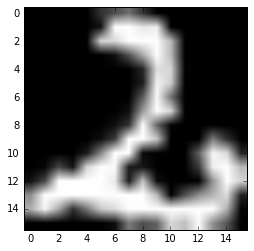

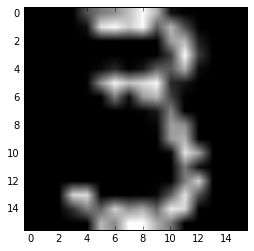

In [2]:
training_data = read_file ( "2015_tme3_usps_train.txt" )

# affichage du 1er chiffre "2" de la base:
display_image ( training_data[2][0] )

# affichage du 5ème chiffre "3" de la base:
display_image ( training_data[3][4] )

## 2. Maximum de vraisemblance pour une classe

In [3]:
def learnML_class_parameters(M):
    return M.mean(axis=0), M.var(axis=0)

#learnML_class_parameters ( training_data[0] )
#learnML_class_parameters ( training_data[1] )

## 3. Maximum de vraisemblance pour toutes les classes

In [4]:
def learnML_all_parameters(train):
    return list(map(learnML_class_parameters, train))

parameters = learnML_all_parameters(training_data)

## 4. Log-vraisemblance d'une image

In [5]:
def pure_numpy_log_likelihood(x, params):
    mu, var = params
    t = np.log(2 * np.pi * var) + ((x - mu) ** 2 / var)
    return - .5 * sum(np.nan_to_num(t))# + np.isnan(t))

def for_numpy_log_likelihood(x, params):
    mu, var = params
    return -.5 * sum([np.log(2 * np.pi * var[i]) + ((x[i] - mu[i]) ** 2 / var[i]) if var[i] != 0 else 0 for i in range(256)])

#compraison de vitesse d'executaion entre les 2 methodes
%time {pure_numpy_log_likelihood(np.random.rand(256), parameters[0]) for _ in range(1000)}
%time {for_numpy_log_likelihood(np.random.rand(256), parameters[0])  for _ in range(1000)}

print("\n==> pure numpy implementation is much faster !! so we will disable warnings and use it...")

CPU times: user 384 ms, sys: 0 ns, total: 384 ms
Wall time: 382 ms
CPU times: user 11 s, sys: 4 ms, total: 11 s
Wall time: 11 s

==> pure numpy implementation is much faster !! so we will disable warnings and use it...


In [6]:
def log_likelihood(x, params):
    mu, var = params
    t = np.log(2 * np.pi * var) + ((x - mu) ** 2 / var)
    return - .5 * sum(np.nan_to_num(t))# + np.isnan(t))

In [7]:
parameters = learnML_all_parameters ( training_data )
test_data = read_file ( "2015_tme3_usps_test.txt" )
log_likelihood ( test_data[2][3], parameters[1] )
print(log_likelihood ( test_data[2][3], parameters[1] ))

assert np.isclose(log_likelihood ( test_data[2][3], parameters[1] ), -36631213.400524415)

-36631213.4005


In [8]:
print([ log_likelihood ( test_data[0][0], parameters[i] ) for i in range ( 10 ) ])

assert np.allclose(
    [ log_likelihood ( test_data[0][0], parameters[i] ) for i in range ( 10 ) ],
    [-80.594309481001218, -2030714328.0707991, -339.70961551873495, -373.97785273732529,-678.16479308314922, -364.62227994586954, -715.4508284953547,  -344286.66839952325,  -499.88159107145611, -35419.208662902507],
    rtol=.1
)

[-80.594309481001218, -2030714328.0707991, -339.70961551873495, -373.97785273732529, -678.16479308314922, -364.62227994586954, -715.4508284953547, -344286.66839952325, -499.88159107145611, -35419.208662902507]


## 5. Log-vraisemblance d'une image (bis)

In [9]:
def log_likelihoods(x, params):
    return [log_likelihood(x, params[i]) for i in range(10)]

In [10]:
print(log_likelihoods ( test_data[1][5], parameters ))

assert np.allclose(
    log_likelihoods ( test_data[1][5], parameters ),
    [-889.22508387,  184.03163176, -185.29589129, -265.13424326, -149.54804688, -215.85994204,  -94.86965712, -255.60771575, -118.95170104,  -71.5970028 ],
    rtol=.3
)

[-889.22508386992899, 184.03163175636334, -185.29589128666683, -265.13424326432369, -149.54804687799918, -215.85994204347998, -94.869657118899056, -255.6077157467451, -118.95170104216609, -71.597002802343141]


## 6. Classification d'une image

In [11]:
def classify_image(x, params):
    return np.array(log_likelihoods(x, params)).argmax()

In [12]:
assert classify_image( test_data[1][5], parameters ) == 1
assert classify_image( test_data[4][1], parameters ) == 9

## 7. Classification de toutes les images

In [13]:
def classify_all_images(test_data, params):
    out = np.zeros((10, 10))
    for image_class, imgs in enumerate(test_data):
        for img in imgs:
            out[image_class, classify_image(img, params)] += 1
    return out[:] / out.sum(axis=1)

%time out = classify_all_images(test_data, parameters)

CPU times: user 7.84 s, sys: 260 ms, total: 8.1 s
Wall time: 7.97 s


In [14]:
assert np.allclose(out.sum(axis=1), [1] * 10, rtol=.2)
assert np.isclose(out[0, 0], 0.84958217, rtol=.2)
assert np.isclose(out[2, 3], 0.040404040404040407, rtol=.2)
assert np.isclose(out[5, 3], 0.050000000000000003, rtol=.2)
out.sum(axis=1)

array([ 1.16080694,  1.04391567,  1.03836375,  0.97498747,  1.06988529,
        0.95038167,  0.98771077,  0.9647159 ,  0.98842635,  1.00031952])

## 8. Affichage du résultat des classifications

In [15]:
from mpl_toolkits.mplot3d import Axes3D

def dessine ( classified_matrix ):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = y = np.linspace ( 0, 9, 10 )
    X, Y = np.meshgrid(x, y)
    ax.plot_surface(X, Y, classified_matrix, rstride = 1, cstride=1 )

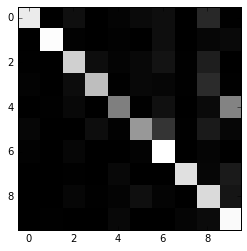

In [16]:
#dessine(out)
plt.imshow(out, cmap='gray', interpolation='nearest')
plt.show()

## 8. Visualize params

### Mean

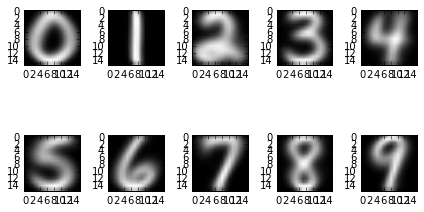

In [17]:
fig, ax = plt.subplots(nrows=2, ncols=5)
for i in range(2):
    for j in range(5):
        ax[i][j].imshow(
            np.array(parameters)[i * 5 + j, 0].reshape((16, 16)),
            cmap='gray'
        )
plt.tight_layout()

### Var

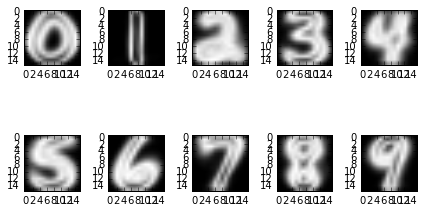

In [18]:
fig, ax = plt.subplots(nrows=2, ncols=5)
for i in range(2):
    for j in range(5):
        ax[i][j].imshow(
            np.array(parameters)[i * 5 + j, 1].reshape((16, 16)),
            cmap='gray'
        )
plt.tight_layout()

## 9. Make the code reusable

In [19]:
class MLEOneClass:
    def __init__(self):
        self.__fitted = False
        
    def fit(self, X):
        """
        Fit the params with the MLE algorithm for one class.
        We will assume all variables independants, and normaly distributed.
        
        :param X: the training data, as list of vectors of same dim
        
        :type X: np.array(np.array(dtype=np.float))
        """
        self.mu  = X.mean(axis=0)
        self.var = X.var(axis=0)
        self.__fitted = True
    
    def log_likelihood(self, X):
        """
        Return the log likelihood of all tests cases.
        
        :param X: list of vector of same dim to compute the log likelihood
        
        :type X: np.array(np.array(dtype=np.float))
        
        :return: the log likelihood of each vector
        :rtype: np.array(dtype=np.float)
        """
        if not self.__fitted:
            raise ValueError("The classifier must be fitted before... :'(")
        def ll(x):
            t = np.log(2 * np.pi * self.var) + (x - self.mu) ** 2 / self.var
            return - .5 * sum(np.nan_to_num(t))# + np.isnan(t))
        return np.array(list(map(ll, X)))
        

class MLEClassifier:
    def __init__(self):
        self.__fitted = False
    
    def fit(self, X, y):
        """
        Fit the classifier params with the Maximum Likelihood Estimation algorithm.
        We will assume all variables independants, and normaly distributed.
        
        :param X: the training data, as list of vectors of same dim
        :param y: the class of each training case, each class is betwen [0, |classes| - 1]
        
        :type X: np.array(np.array(dtype=np.float))
        :type y: np.array(int)
        """
        nb_classes = len(set(y))
        self.classes = [MLEOneClass() for _ in range(nb_classes)]
        #fit each class
        for i in range(nb_classes):
            training_data = np.array(list(zip(*filter(lambda t: t[1] == i, zip(X, y)))))[0]
            self.classes[i].fit(training_data)
        self.__fitted = True
        
    def log_likelihood(self, X):
        """
        Return the log likelihood of all tests cases of all classes.
        
        :param X: list of vector of same dim to compute the log likelihood
        
        :type X: np.array(np.array(dtype=np.float))
        
        :return: the log likelihood of each vector for each class
        :rtype: np.array(np.array(dtype=np.float))
        """
        return np.array([c.log_likelihood(X) for c in self.classes])
    
    def predict(self, X):
        """
        Return the class of all tests cases.
        
        :param X: list of vector of same dim to compute the class
        
        :type X: np.array(np.array(dtype=np.float))
        
        :return: the class of each vector
        :rtype: np.array(dtype=np.int)
        """
        if not self.__fitted:
            raise ValueError("The classifier must be fitted before... :'(")
        return self.log_likelihood(X).argmax(axis=0)
    

In [20]:
X_train = []
y_train = []
for i, c in enumerate(training_data):
    y_train += [i] * len(c)
    X_train.extend(c)

X_train = np.array(X_train)
y_train = np.array(y_train)

In [21]:
X_test = []
y_test = []
for i, c in enumerate(test_data):
    y_test += [i] * len(c)
    X_test.extend(c)

X_test = np.array(X_test)
y_test = np.array(y_test)

In [22]:
clf = MLEClassifier()
clf.fit(X_train, y_train)

In [23]:
%time accuracy = sum(clf.predict(X_test) == y_test) / len(y_test)
print(accuracy * 100)

CPU times: user 7.9 s, sys: 68 ms, total: 7.97 s
Wall time: 7.91 s
77.528649726


## 10. Stack classifiers

In [24]:
X_train2 = np.exp(clf.log_likelihood(X_train).T)
X_test2  = np.exp(clf.log_likelihood(X_test).T)

In [25]:
#normalize
X_train2 = X_train2 / X_train2.sum(axis=0)
X_test2  = X_test2  / X_test2.sum(axis=0)

In [26]:
clf2 = MLEClassifier()
clf2.fit(X_train2, y_train)

In [27]:
%time accuracy2 = sum(clf2.predict(X_test2) == y_test) / len(y_test)
print(accuracy2 * 100)

CPU times: user 5.95 s, sys: 200 ms, total: 6.15 s
Wall time: 6.04 s
53.5127055306
